# Submitted by Roten Gabay and Nitzan Tal

In [38]:
import os

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import math

# Enable inline plotting
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

--- Create and Train a Simple MNIST CNN Classifier ---

In [39]:
''' Build a simple MNIST classification CNN
    The network takes ~3 minutes to train on a normal laptop and reaches roughly 97% of accuracy
    Model structure: Conv, Conv, Max pooling, Dropout, Dense, Dense
'''
def build_mnist_model():
    
    activation = 'relu'
    # input image dimensions
    img_rows, img_cols, img_colors = 28, 28, 1
    
    model = keras.Sequential()
    model.add(layers.Conv2D(8, kernel_size=(3, 3), input_shape=(img_rows, img_cols, img_colors), activation=activation))
    model.add(layers.Conv2D(8, (3, 3), activation=activation))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.25))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation=activation))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes))
    model.add(layers.Activation('softmax', name='y_pred'))
              
    return model

In [40]:
''' Normalize input to the range of [0..1]
    Apart from assisting in the convergance of the training process, this 
    will also make our lives easier during the adversarial attack process
'''
def normalize(x_train,x_test):
    x_train -= x_train.min()
    x_train /= x_train.max()
    x_test -= x_test.min()
    x_test /= x_test.max()
    
    return x_train, x_test

In [41]:
# Load and prepare the datasets for training
num_classes = 10

img_rows, img_cols, img_colors = 28, 28, 1
(train_images, train_labels), (test_images, test_labels) = keras.datasets.mnist.load_data()
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')
train_images = train_images.reshape(train_images.shape[0], img_rows, img_cols, 1)
test_images = test_images.reshape(test_images.shape[0], img_rows, img_cols, 1)
train_images, test_images = normalize(train_images, test_images)
    
train_labels = keras.utils.to_categorical(train_labels, num_classes)
test_labels = keras.utils.to_categorical(test_labels, num_classes)

In [42]:
# Train the model
batch_size = 128
maxepoches = 12
learning_rate = 0.1
lr_decay = 1e-6
lr_drop = 20

def lr_scheduler(epoch):
    return learning_rate * (0.5 ** (epoch // lr_drop))
reduce_lr = keras.callbacks.LearningRateScheduler(lr_scheduler)

model = build_mnist_model()

model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adadelta(),
              metrics=[keras.metrics.CategoricalAccuracy()])

history = model.fit(train_images, train_labels,
                    batch_size=batch_size,
                    epochs=maxepoches,
                    verbose=1,
                    validation_data=(test_images, test_labels),
                    callbacks=[reduce_lr])


Epoch 1/12
469/469 [==============================] - 4s 8ms/step - loss: 1.5910 - categorical_accuracy: 0.4622 - val_loss: 0.3215 - val_categorical_accuracy: 0.9109
Epoch 2/12
469/469 [==============================] - 3s 7ms/step - loss: 0.5051 - categorical_accuracy: 0.8432 - val_loss: 0.2551 - val_categorical_accuracy: 0.9291
Epoch 3/12
469/469 [==============================] - 3s 7ms/step - loss: 0.4214 - categorical_accuracy: 0.8717 - val_loss: 0.2170 - val_categorical_accuracy: 0.9377
Epoch 4/12
469/469 [==============================] - 3s 7ms/step - loss: 0.3734 - categorical_accuracy: 0.8875 - val_loss: 0.1917 - val_categorical_accuracy: 0.9445
Epoch 5/12
469/469 [==============================] - 3s 7ms/step - loss: 0.3309 - categorical_accuracy: 0.9008 - val_loss: 0.1679 - val_categorical_accuracy: 0.9520
Epoch 6/12
469/469 [==============================] - 3s 7ms/step - loss: 0.2967 - categorical_accuracy: 0.9107 - val_loss: 0.1520 - val_categorical_accuracy: 0.9564
Epoc

--- Fast Gradient Sign Method (FGSM) ---

In [43]:
''' A simple utility funcion for evaluating the success of an attack
'''
def TestAttack(model, adv_images, orig_images, true_labels, target_labels=None, targeted=False):
    score = model.evaluate(adv_images, true_labels, verbose=0)
    success=1 - score[1]
    print('Test loss: {:.2f}'.format(score[0]))
    print('Successfully moved out of source class: {:.2f}'.format( 1 - score[1]))
    
    if targeted:
        score = model.evaluate(adv_images, target, verbose=0)
        print('Test loss: {:.2f}'.format(score[0]))
        print('Successfully perturbed to target class: {:.2f}'.format(score[1]))
    
    dist = np.mean(np.sqrt(np.mean(np.square(adv_images - orig_images), axis=(1,2,3))))
    print('Mean perturbation distance: {:.2f}'.format(dist))
    print('A random example of one adverserial image in the set')
    index = np.random.randint(0,adv_images.shape[0])
    img = adv_images[index].reshape(28, 28)
    plt.imshow(img, cmap='gray')
    plt.show()
    return success, dist

In [44]:
''' Fast Gradient Sign Method implementation - perturb all input features by an epsilon sized step in 
    the direction of loss gradient
'''
def FastGradientSignMethod(model, images, labels, epsilon=0.3):

    # The GradientTape is the context at which we can explicitly ask for gradient calculation
    # We define the relevant tensors inside that context, and ask for the gradient calculation outside of it
    with tf.GradientTape() as grad:
      true_label_tensor = tf.Variable(labels, dtype=tf.float32)
      input_tensor = tf.Variable(images, dtype=tf.float32)
      predicted = model(input_tensor)
      adv_loss = keras.losses.categorical_crossentropy(true_label_tensor, predicted)
    adv_grads = grad.gradient(adv_loss, input_tensor)

    # Finally, the FGSM formula is rather straight forward x`= x + epsilon * sign(loss(x,y))
    delta = tf.multiply(epsilon, tf.cast(tf.sign(adv_grads), dtype=tf.float32))
    adv_out = input_tensor + delta
    return adv_out.numpy()

Test loss: 4.77
Successfully moved out of source class: 0.96
Mean perturbation distance: 0.30
A random example of one adverserial image in the set


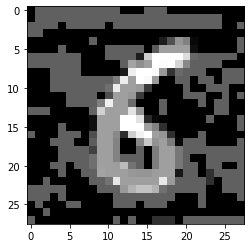

(0.9598000012338161, 0.29746908)

In [45]:
# Compute perturbations using FGSM
adv_images = FastGradientSignMethod(model, test_images, test_labels, epsilon=0.3)
TestAttack(model, adv_images, test_images, test_labels, targeted=False)


The following function implements the re-training process and also prints examples for each set of adverserial examples. 

attack with X0
Test loss: 4.69
Successfully moved out of source class: 0.95
Mean perturbation distance: 0.30
A random example of one adverserial image in the set


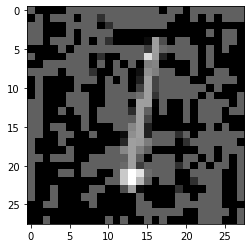

Retraining with augmented samples
477/477 - 2s - loss: 0.2526 - categorical_accuracy: 0.9291 - val_loss: 0.0960 - val_categorical_accuracy: 0.9717
attack with X1
Test loss: 3.25
Successfully moved out of source class: 0.90
Mean perturbation distance: 0.30
A random example of one adverserial image in the set


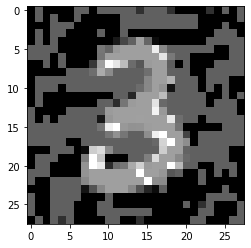

attack with X0
Test loss: 3.27
Successfully moved out of source class: 0.91
Mean perturbation distance: 0.30
A random example of one adverserial image in the set


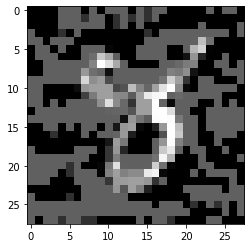

Retraining with augmented samples
485/485 - 2s - loss: 0.2748 - categorical_accuracy: 0.9209 - val_loss: 0.0934 - val_categorical_accuracy: 0.9724
attack with X2
Test loss: 2.48
Successfully moved out of source class: 0.82
Mean perturbation distance: 0.30
A random example of one adverserial image in the set


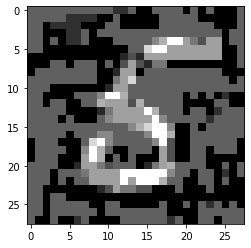

attack with X0
Test loss: 2.46
Successfully moved out of source class: 0.83
Mean perturbation distance: 0.30
A random example of one adverserial image in the set


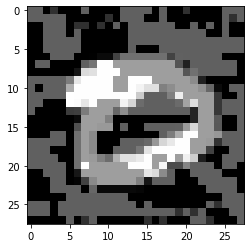

Retraining with augmented samples
493/493 - 3s - loss: 0.2870 - categorical_accuracy: 0.9134 - val_loss: 0.0899 - val_categorical_accuracy: 0.9737
attack with X3
Test loss: 2.41
Successfully moved out of source class: 0.80
Mean perturbation distance: 0.30
A random example of one adverserial image in the set


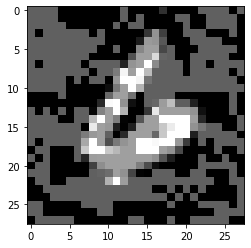

attack with X0
Test loss: 2.07
Successfully moved out of source class: 0.72
Mean perturbation distance: 0.30
A random example of one adverserial image in the set


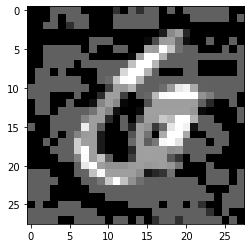

Retraining with augmented samples
500/500 - 3s - loss: 0.3026 - categorical_accuracy: 0.9057 - val_loss: 0.0860 - val_categorical_accuracy: 0.9742
attack with X4
Test loss: 2.26
Successfully moved out of source class: 0.75
Mean perturbation distance: 0.30
A random example of one adverserial image in the set


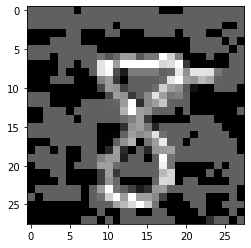

attack with X0
Test loss: 1.86
Successfully moved out of source class: 0.66
Mean perturbation distance: 0.30
A random example of one adverserial image in the set


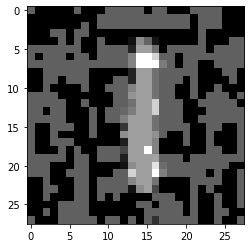

Retraining with augmented samples
508/508 - 3s - loss: 0.3155 - categorical_accuracy: 0.9005 - val_loss: 0.0829 - val_categorical_accuracy: 0.9759
attack with X5
Test loss: 1.92
Successfully moved out of source class: 0.64
Mean perturbation distance: 0.30
A random example of one adverserial image in the set


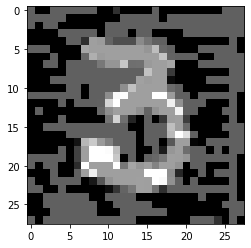

attack with X0
Test loss: 1.68
Successfully moved out of source class: 0.58
Mean perturbation distance: 0.30
A random example of one adverserial image in the set


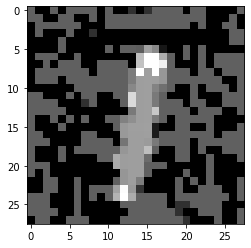

Retraining with augmented samples
516/516 - 3s - loss: 0.3216 - categorical_accuracy: 0.8982 - val_loss: 0.0786 - val_categorical_accuracy: 0.9760


In [46]:
def adv_retrain(model, train_images_i, train_labels_i):  
  table_res=np.zeros((6,4))


  for i in range(6):
    adv_idx= np.random.choice(test_images.shape[0],size=1000, replace=False )
    adv_images = FastGradientSignMethod(model, test_images[adv_idx], test_labels[adv_idx], epsilon=0.3)
    print(f'attack with X{i}')
    table_res[i,2], table_res[i,3]=TestAttack(model, adv_images, test_images[adv_idx], test_labels[adv_idx], targeted=False)
     
    if i==0:
      adv_images_0=adv_images.copy()
      adv_idx_0=adv_idx
      table_res[i,1]=table_res[i,2]
       
    else:
      print('attack with X0') 
      
      table_res[i,1], _=TestAttack(model, adv_images_0, test_images[adv_idx_0], test_labels[adv_idx_0], targeted=False)
      #print(model.evaluate(test_images, test_labels, verbose=0))
    train_images_i= np.vstack((train_images_i,adv_images))
    train_labels_i= np.vstack((train_labels_i,test_labels[adv_idx]))
    print('Retraining with augmented samples')
    history = model.fit(train_images_i, train_labels_i,
                        batch_size=batch_size,
                        epochs=1,
                        verbose=2,
                        validation_data=(test_images, test_labels),
                        callbacks=[reduce_lr])
    table_res[i,0]=history.history['val_categorical_accuracy'][-1]
  return table_res

 
table_res=adv_retrain(model, train_images, train_labels)

 

The table:
(note that for the 0 iteration Xi is actually X0)

In [47]:
import pandas as pd
cols=['Clean data accuracy', 'Attack success rate for X0', 'Attack success rate for Xi', 'Mean L2 perturbation distance for Xi']
summary=pd.DataFrame(table_res, columns=cols)
summary.index.name = 'iteration'
summary

,Clean data accuracy,Attack success rate for X0,Attack success rate for Xi,Mean L2 perturbation distance for Xi
iteration,,,,
0,0.9717,0.951,0.951,0.297479
1,0.9724,0.913,0.900,0.297553
2,0.9737,0.833,0.819,0.297707
3,0.9742,0.722,0.803,0.299620
4,0.9759,0.663,0.753,0.299602
5,0.9760,0.583,0.638,0.299660


Hooray! Our defense worked - with every iteration the attack rates decreased both for the old set and for new sets.